In [1]:
import numpy as np 

np.random.seed(4)

A = np.random.randn(2, 3) # 2 samples, 3 classes 

A_prob = np.exp(A)/np.exp(A).sum(axis=1, keepdims=True)

print(A_prob)

[[0.34263822 0.53703581 0.12032597]
 [0.69861461 0.22979767 0.07158772]]


In [2]:
labels = np.array([1,0]) 

In [3]:
scores = np.zeros(A_prob.shape[0])

for loc, cls in enumerate(labels):
    scores[loc] = A_prob[loc, cls]

print(scores)

[0.53703581 0.69861461]


In [4]:
scores = A_prob[:, labels]

print(scores)

[[0.53703581 0.34263822]
 [0.22979767 0.69861461]]


In [5]:
scores = A_prob[np.arange(2), labels]

print(scores)

[0.53703581 0.69861461]


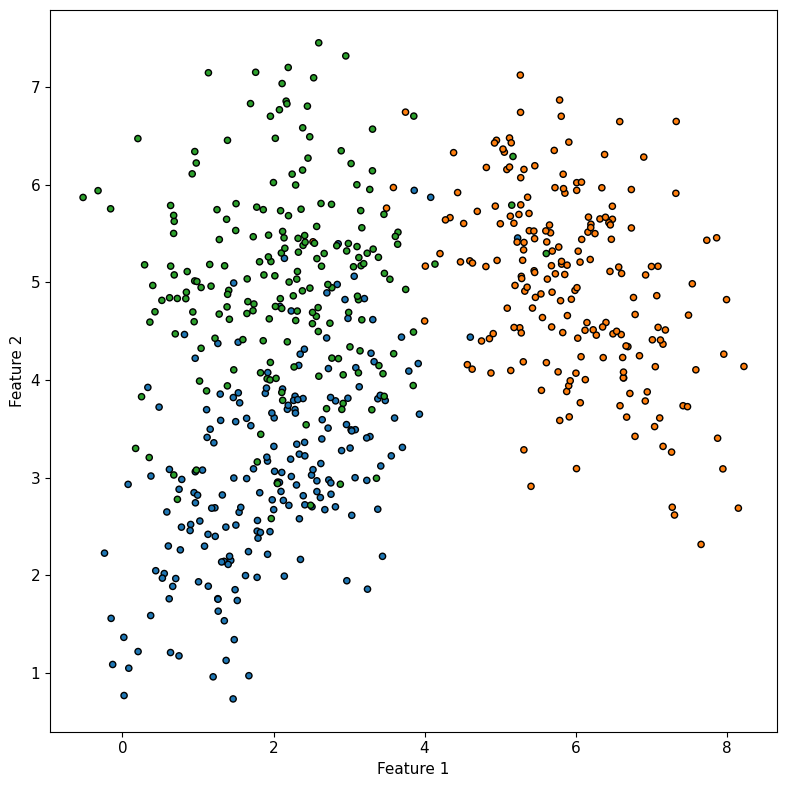

In [6]:
import numpy as np
import matplotlib.pyplot as plt 

# Set random seed for reproducibility
np.random.seed(5)

# Generate synthetic data for three-class classification
mean_class_1 = [2, 3]
cov_class_1 = [[1, 0.5], [0.5, 1]]
data_class_1 = np.random.multivariate_normal(mean_class_1, cov_class_1, 200)

mean_class_2 = [6, 5]
cov_class_2 = [[1, -0.5], [-0.5, 1]]
data_class_2 = np.random.multivariate_normal(mean_class_2, cov_class_2, 200)

mean_class_3 = [2, 5]
cov_class_3 = [[1, 0], [0, 1]]
data_class_3 = np.random.multivariate_normal(mean_class_3, cov_class_3, 200)

# Combine the three classes into a single dataset
X = np.vstack((data_class_1, data_class_2, data_class_3))
y = np.hstack((np.zeros(200, dtype=int), np.ones(200, dtype=int),
               2 * np.ones(200, dtype=int)))  

# Plot the synthetic data

fig = plt.figure(figsize=(8,8))

plt.rcParams.update({'font.size': 11, "figure.figsize": (4,3)})
colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c", 3: "#d62728"}
y_col = list(map(colors.get, y))


plt.scatter(X[:, 0], X[:, 1], c=y_col, marker='o', s=20, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split


X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=1/3, random_state=42)


X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=1/2, random_state=42)

print(X_train.shape, X_cal.shape, X_test.shape)

(200, 2) (200, 2) (200, 2)


In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_cal)

print(y_prob[:5])

[[8.85131451e-01 3.22026672e-05 1.14836346e-01]
 [7.61705123e-02 5.11361835e-01 4.12467653e-01]
 [6.83086508e-02 2.89111056e-05 9.31662438e-01]
 [1.71799448e-01 9.32283777e-03 8.18877715e-01]
 [8.06610622e-01 4.16057041e-02 1.51783674e-01]]


In [9]:
n2 = X_cal.shape[0]

cal_scores = 1 - y_prob[np.arange(n2), y_cal]

print(cal_scores[:5])

[0.11486855 0.48863817 0.06833756 0.18112229 0.19338938]


In [10]:
# Get adjusted quantile

def find_quantile(cal_scores, n2, alpha):

    q_level = np.ceil((n2+1)*(1-alpha))/n2

    qhat = np.quantile(cal_scores, q_level, method='higher')
    
    return qhat 

In [11]:
# Plot calibration scores and adjusted quantile for various alpha 

def plot_scores(alphas, cal_scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(5, 3))
    plt.rcParams.update({'font.size': 12})
    plt.hist(cal_scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=150,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}"
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

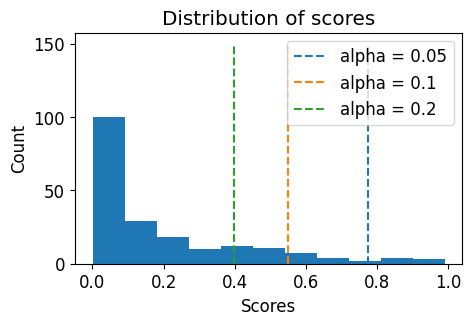

In [12]:
alphas = [0.05, 0.1, 0.2]

quantiles = [find_quantile(cal_scores, n2, alpha) for alpha in alphas]

plot_scores(alphas, cal_scores, quantiles)

In [13]:
# Build the prediction set (one alpha only)

qhat = find_quantile(cal_scores, n2, alpha=0.05)

prediction_sets = clf.predict_proba(X_test) >= (1-qhat) 

In [14]:
prediction_sets[:5]

array([[ True, False, False],
       [ True, False,  True],
       [ True, False,  True],
       [ True, False, False],
       [ True, False,  True]])

In [15]:
# Mean width of prediction set

prediction_sets.sum(axis=1).mean()

1.225

In [16]:
# Effective coverage score
# The fraction of true labels that lie within the prediction sets

prediction_sets[np.arange(X_test.shape[0]), y_test]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,

In [17]:
prediction_sets[np.arange(X_test.shape[0]), y_test].mean()

0.96